In [ ]:
# Custom Data from github
!git clone https://github.com/sktdebnath/bhavana.git

###Custom Training
This is for your convenienece. We have already trained the model.

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
import torch

# Check for CUDA availability and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define device

# Initialize the model
model = YOLO('Your YOLO Weights (.pt) File Location')

# Define the training settings
train_settings = {
    'data'    : 'Your .yaml Path location', # Your YAML Path
    'epochs'  : 100,
    'cos_lr'  : True,
    'patience': 50,
    'seed'    : 42,
    'batch'   :-1,
    'imgsz'   : 640,
    'device'  : device,
    'plots'   : True
}

# Train the model with the specified settings
model.train(**train_settings)

# Empty cache for an efficient memory management.
torch.cuda.empty_cache()

###Object Detection

In [ ]:
from google.colab import files
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch
from scipy.interpolate import splprep, splev
import os


image 1/1 /content/bhavana/C1-50000.jpg: 2304x2304 182 Rs, 134.3ms
Speed: 28.2ms preprocess, 134.3ms inference, 1333.2ms postprocess per image at shape (1, 3, 2304, 2304)


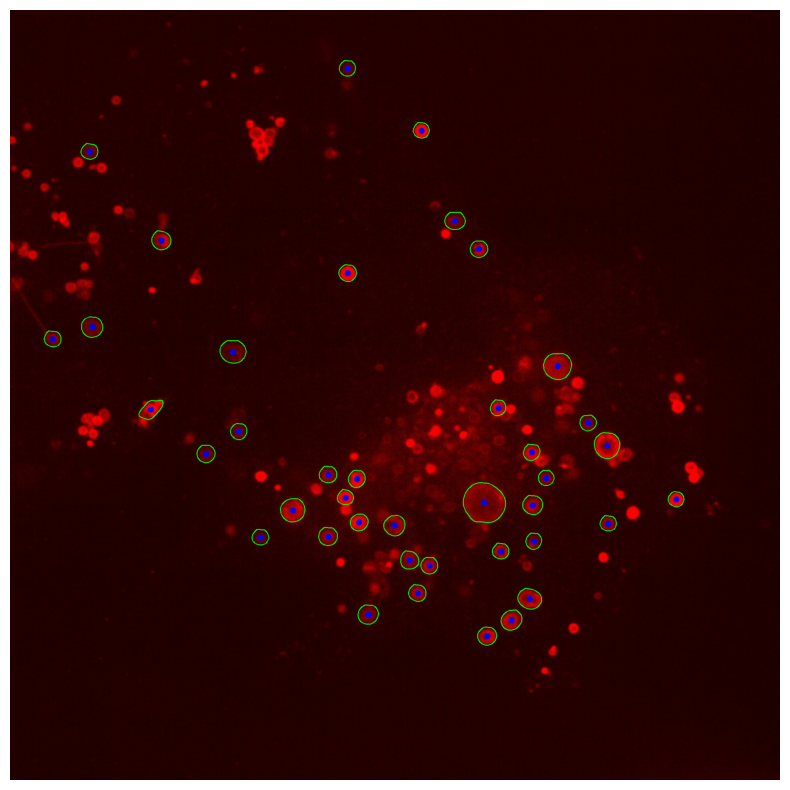

In [4]:
# Load a pretrained YOLOv8 model
model = YOLO("/content/bhavana/best.pt")

# Load the image
image_path = "/content/bhavana/C1-50000.jpg"  # Path to your uploaded image
image      = cv2.imread(image_path)
image_rgb  = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

area_small  = image_rgb.copy()
area_medium = image_rgb.copy()
area_large  = image_rgb.copy()

# Check for CUDA availability and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define device

# Run the model on the image
results = model(image_path, conf=0.30, device=device, iou=0.4,
                retina_masks=True, imgsz=image_rgb.shape[0]) ### Use imgsz=640

# Create an empty mask image to accumulate the masks
mask_accumulator = np.zeros(image.shape[:2], dtype=np.uint8)

# Process results
for result in results:
    masks = result.masks  # Masks object for segmentation masks outputs

    # Get the coordinates of the masks
    xy = masks.xy  # List of arrays with (x, y) coordinates of mask vertices

    # Draw each mask separately with a random color
    for i, polygon in enumerate(xy):
        polygon = polygon.astype(np.int32)  # Ensure the coordinates are integers

        # Create an empty mask for each polygon
        mask = np.zeros_like(mask_accumulator)
        cv2.fillPoly(mask, [polygon], 255)

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Approximate each contour using B-splines and plot centroids
        for contour in contours:
            contour = contour[:, 0, :]  # Simplify contour array

            # Calculate the centroid of the contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0

            tck, u = splprep(contour.T, s=100.0)  # s is the smoothing factor
            new_points = splev(np.linspace(0, 1, 50), tck)
            new_points = np.stack(new_points, axis=-1).astype(np.int32)

            area = cv2.contourArea(contour)
            # Filter based on area
            if area < 800 and area > 10:
                cv2.polylines(area_small, [new_points], isClosed=True, color=(0, 255, 0), thickness=2)
                cv2.circle(area_small, (cX, cY), 9, (0, 0, 255), -1)  # Green circle for centroid
            elif area >= 800 and area <1600:
                cv2.polylines(area_medium, [new_points], isClosed=True, color=(0, 255, 0), thickness=2)
                cv2.circle(area_medium, (cX, cY), 9, (0, 0, 255), -1)  # Green circle for centroid
            else:
                cv2.polylines(area_large, [new_points], isClosed=True, color=(0, 255, 0), thickness=2)
                cv2.circle(area_large, (cX, cY), 9, (0, 0, 255), -1)  # Green circle for centroid

# Display the original image with overlaid smoothed contours and centroids
plt.figure(figsize=(10, 10))
plt.imshow(area_large)
plt.axis('off')
plt.show()